# Fix pathing

In [1]:
import sys


sys.path.append("../..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))))


# Imports

In [3]:
import plotter
import datahandler

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display


# Constants

In [4]:
FOLDER_NAME = "ex_4_most_NONE"

FOLDER_PATH = os.path.join(os.path.dirname(constants.PROJECT_DIRECTORY_PATH), "Simulator", "data")


# Methods

In [5]:
def load_csv(folder_name, filename = "events"):
    dataframes = []
    for seed in list(range(10)):
        dataframes.append(pd.read_csv(os.path.join(FOLDER_PATH, folder_name, filename + "_seed=" + str(seed) + ".csv")))
    
    dataframe = pd.concat(dataframes, ignore_index=True)

    response_time_cols = [
        'duration_incident_creation',
        'duration_resource_appointment',
        'duration_resource_preparing_departure',
        'duration_dispatching_to_scene'
    ]
    dataframe['total_response_time'] = dataframe[response_time_cols].sum(axis=1)

    dataframe["complied"] = np.nan
    # Define the criteria for response times
    criteria = {
        ('A', True): 12 * 60,
        ('A', False): 25 * 60,
        ('H', True): 30 * 60,
        ('H', False): 40 * 60
    }

    for (triage, urban), group in dataframe.groupby(['triage_impression_during_call', 'urban']):
        if triage == 'V1':
            continue
    
        limit = criteria.get((triage, urban))
        if limit is not None:
            dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit

    return dataframe


In [6]:
def plot_response_time_density(df):
    matplotlib.pyplot.figure(figsize=(12, 8))

    for triage_category in ["A", "H", "V1"]:
        subset = df[df['triage_impression_during_call'] == triage_category]
        sns.kdeplot(subset['total_response_time'] / 60, bw_adjust=0.5, label=f'Triage {triage_category}', fill=True)

    matplotlib.pyplot.title('Response Time Density by Triage Category')
    matplotlib.pyplot.xlabel('Response Time (minutes)')
    matplotlib.pyplot.ylabel('Density')
    matplotlib.pyplot.xlim(left=0)
    matplotlib.pyplot.legend()
    matplotlib.pyplot.show()


In [7]:
def print_table(df: pd.DataFrame):
    # Use a dictionary within agg to specify aggregations for different columns
    stats = df.groupby(['triage_impression_during_call', 'urban']).agg({
        'total_response_time': ['mean', 'median'],
        'complied': 'mean'  # Calculate the mean of the boolean 'complied', which effectively gives the compliance rate
    }).reset_index()

    # Flatten the multi-level column names resulting from aggregation
    stats.columns = ['Triage', 'Urban', 'Mean Response Time', 'Median Response Time', 'Compliance Rate']

    # Convert response times from seconds to minutes and round to 2 decimal places
    stats['Mean Response Time'] = (stats['Mean Response Time'] / 60).round(2)
    stats['Median Response Time'] = (stats['Median Response Time'] / 60).round(2)

    # Convert the compliance rate to percentage and round to 2 decimal places
    # Fill NaN values with 'N/A' for compliance rate
    stats['Compliance Rate'] = stats['Compliance Rate'].apply(lambda x: f"{x*100:.2f}%" if pd.notna(x) else "N/A")

    # Map boolean 'Urban' to 'Yes' or 'No'
    stats['Urban'] = stats['Urban'].map({True: 'Yes', False: 'No'})

    # Sort the DataFrame
    stats.sort_values(by=["Urban", "Triage"], ascending=[False, True], inplace=True)

    # Display the DataFrame using IPython display capabilities, hiding the index
    IPython.display.display(stats.style.hide(axis='index'))


In [8]:
def print_info(dataframe: pd.DataFrame):
    filtered_df = dataframe.dropna(subset=['complied'])

    # compliance
    numerator = filtered_df['complied'].count()
    true_count = filtered_df['complied'].sum()

    compliance_rate = true_count / numerator

    print(f"Compliance Rate: {(abs(compliance_rate - 1) * 100):.2f}")

    # complaince (U)
    # compliance (R)
    compliance_rates = filtered_df.groupby('urban')['complied'].agg(lambda x: x.mean())

    groups = []
    rates = []

    for group, rate in compliance_rates.items():
        groups.append(group)
        rates.append(rate)
    
    for group, rate in zip(groups[::-1], rates[::-1]):
        print(f"Compliance Rate for {'Urban' if group else 'Non-Urban'}: {(abs(rate - 1) * 100):.2f}")


# Main

In [9]:
dataframe_acc = load_csv(folder_name=FOLDER_NAME, filename="events_ACC")
dataframe_ga = load_csv(folder_name=FOLDER_NAME, filename="events_GA")
dataframe_ip = load_csv(folder_name=FOLDER_NAME, filename="events_IP")
dataframe_ma = load_csv(folder_name=FOLDER_NAME, filename="events_MA")
dataframe_ouh = load_csv(folder_name=FOLDER_NAME, filename="events_OUH")
dataframe_pp = load_csv(folder_name=FOLDER_NAME, filename="events_PP")
dataframe_r = load_csv(folder_name=FOLDER_NAME, filename="events_R")
dataframe_sls = load_csv(folder_name=FOLDER_NAME, filename="events_SLS")
dataframe_u = load_csv(folder_name=FOLDER_NAME, filename="events_U")
dataframe_ur = load_csv(folder_name=FOLDER_NAME, filename="events_UR")


C:\Users\sindr\AppData\Local\Temp\ipykernel_9588\1836784098.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False  True  True False  True False False  True False False
  True  True  True False False False  True  True  True  True False  True
  True  True  True  True  True  True False False False  True  True False
  True  True False  True  True  True  True  True  True False False False
  True  True False False  True False  True False  True  True  True  True
 False False False  True  True False  True False False  True  True  True
  True  True  True False False False  True False False  True  True False
  True False  True  True  True  True False False False  True  True False
  True  True False  True False  True  True  True False False False False
  True  True False  True False False  True False False  True  True  True
 False False  True  True  True False  True  True False  True False  True
  True  True

In [10]:
print_info(dataframe_ur)


Compliance Rate: 27.43
Compliance Rate for Urban: 28.94
Compliance Rate for Non-Urban: 16.96


C:\Users\sindr\AppData\Local\Temp\ipykernel_9588\1836784098.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True False False False  True  True  True False  True  True  True
  True False False  True  True False False  True  True  True False False
  True  True  True  True False  True  True  True  True False  True  True
  True False False  True  True  True  True False  True  True  True False
 False  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit
C:\Users\sindr\AppData\Local\Temp\ipykernel_9588\1836784098.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True False  True  True  True False  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True False False
  True  

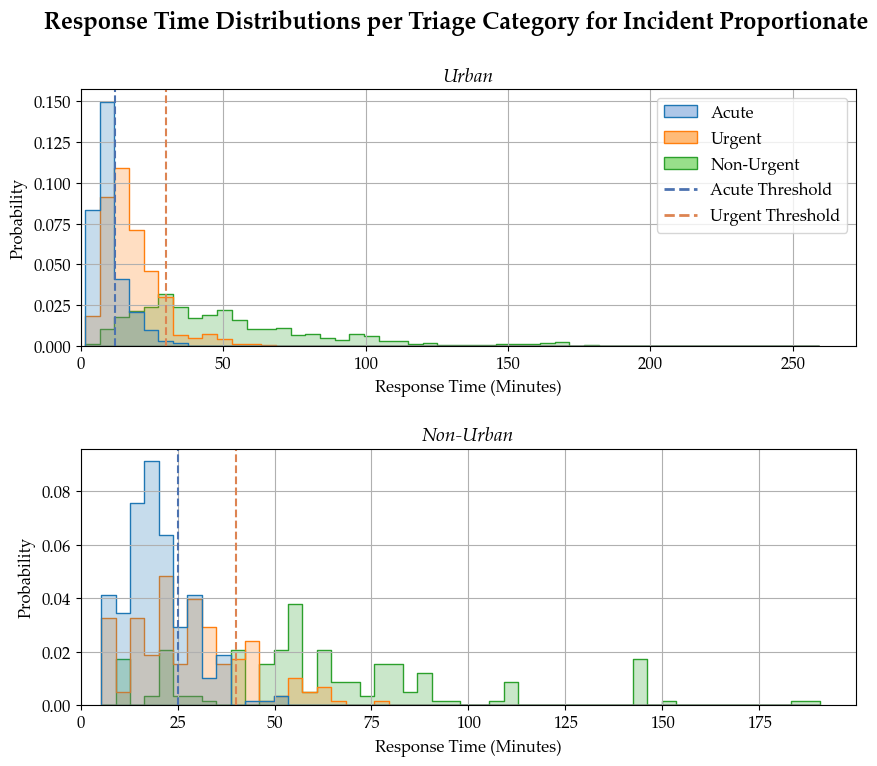

In [14]:
df = pd.concat([
    load_csv(folder_name="ex_4_least_NONE", filename="events_IP"),
    load_csv(folder_name="ex_4_avg_NONE", filename="events_IP"),
    load_csv(folder_name="ex_4_most_NONE", filename="events_IP")
])
df['response_time'] = df['total_response_time'] / 60

category_mapping = {
    'A': 'Acute',
    'H': 'Urgent',
    'V1': 'Non-Urgent'
}

df['Triage Impression'] = df['triage_impression_during_call'].map(category_mapping)
df['Triage Impression'] = pd.Categorical(df['Triage Impression'], categories=["Acute", "Urgent", "Non-Urgent"], ordered=True)

# Define the color map and line styles
palette = sns.color_palette("tab20")
triage_colors = {'Acute': (palette[0], palette[1]), 'Urgent': (palette[2], palette[3]), 'Non-Urgent': (palette[4], palette[5])}
acute_line_color = sns.color_palette("deep")[0]
urgent_line_color = sns.color_palette("deep")[1]

# Create your plots as previously
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

title = "Response Time Distributions per Triage Category for Incident Proportionate"
fig.suptitle(title, **constants.FONT_PROPERTIES_HEADER)

sns.histplot(data=df[df["urban"] == True], ax=axs[0], x='response_time', hue='Triage Impression', element="step", stat="probability", common_norm=True, palette=triage_colors, bins=50)
axs[0].axvline(12, color=acute_line_color, linestyle='--', linewidth=1.5)
axs[0].axvline(30, color=urgent_line_color, linestyle='--', linewidth=1.5)
axs[0].set_xlim(left=0)
axs[0].set_xlabel("Response Time (Minutes)")
axs[0].set_title("Urban", fontdict=constants.FONT_PROPERTIES_SUB_HEADER)
axs[0].grid(True)

sns.histplot(data=df[df["urban"] == False], ax=axs[1], x='response_time', hue='Triage Impression', element="step", stat="probability", common_norm=True, palette=triage_colors, bins=50, legend=False)
axs[1].axvline(25, color=acute_line_color, linestyle='--', linewidth=1.5)
axs[1].axvline(40, color=urgent_line_color, linestyle='--', linewidth=1.5)
axs[1].set_xlim(left=0)
axs[1].set_xlabel("Response Time (Minutes)")
axs[1].set_title("Non-Urban", fontdict=constants.FONT_PROPERTIES_SUB_HEADER)
axs[1].grid(True)

# Create handles for the legend
handles = [
    mpatches.Patch(edgecolor=triage_colors['Acute'][0], facecolor=triage_colors['Acute'][1], label='Acute'),
    mpatches.Patch(edgecolor=triage_colors['Urgent'][0], facecolor=triage_colors['Urgent'][1], label='Urgent'),
    mpatches.Patch(edgecolor=triage_colors['Non-Urgent'][0], facecolor=triage_colors['Non-Urgent'][1], label='Non-Urgent'),
    mlines.Line2D([], [], color=acute_line_color, linestyle='--', linewidth=2, label='Acute Threshold'),
    mlines.Line2D([], [], color=urgent_line_color, linestyle='--', linewidth=2, label='Urgent Threshold')
]

# Update the legends for each subplot with the combined handles
axs[0].legend(handles=handles, loc='upper right')

plt.subplots_adjust(hspace=0.4)

plt.savefig(f'../plots/{title}.png', dpi=300, bbox_inches='tight')

plt.show()
